# Drivers of Zestimate Error
Jason Tellez

9/28/21

---
## Goals:

- Take an in-depth look to find what characteristics of a single-unit/single-family residence create the biggest increase in Zestimate error (logerror)
- Single-unit/single-family residences with transactions in 2017
- Explore the data to test any hypotheses I may have about the data
- Create and compare ML models to find what best predicts the error

#### Unit types acquired
- 261: Single Family Residential
- 262: Rural Residence
- 263: Mobile Home
- 264: Townhouse
- 265: Cluster home
- 266: Condominium
- 268: Row House
- 271: Timeshare
- 273: Bungalow
- 274: Zero Lot Line
- 275: Manufactured, Modular, Prefabricated Home
- 276: Patio Home
- 279: Inferred Single Family Residential
 
## Executive Summary 
- I found that when bedroom count may be a driver for logerror.
- I found that there was no linear relationship between tax value of property and logerror.
- Using square feet and age of property, I found that when I created 5 clusters, the mean logerror was equal across all clusters
- Using latitude, longitude and heating/airconditioning type, I found that when i created 6 clusters, the mean logerror was different across all clusters.
- Using bathroom count, tax rate, and county, I found that when i created 5 clusters, the mean logerror was equal across all clusters.
- I found that my models are not adequete predictors of logerror.

In [1]:
import os
from env import host, user, password
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import median_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.neighbors import KNeighborsRegressor

from scipy import stats

import acquire as a
import prepare as p
import model as m

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Acquire

- Connect to SQL database using credentials
- Query the data to gather single-unit/single-family residences
- save as csv file
- convert to pandas dataframe for analysis

In [2]:
df = a.get_zillow_data()
a.summarize_stats(df)

YOU CAN'T HANDLE THE STATS!!!!!!
|------------------------------------------------------|
|------------------------------------------------------|
Shape: (72085, 68)
|------------------------------------------------------|
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72085 entries, 0 to 72084
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            72085 non-null  int64  
 1   parcelid                      72085 non-null  int64  
 2   airconditioningtypeid         23023 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   72085 non-null  float64
 6   bedroomcnt                    72085 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         44951 non-null  float64
 9   calculatedbath

count   71841.00000
mean        2.19681
std         0.92678
min         1.00000
25%         2.00000
50%         2.00000
75%         3.00000
max        18.00000
Name: fullbathcnt, dtype: float64

2.00000     36486
3.00000     16393
1.00000     14198
4.00000      3185
5.00000      1043
6.00000       361
7.00000        96
8.00000        56
9.00000        13
10.00000        5
11.00000        3
13.00000        1
18.00000        1
Name: fullbathcnt, dtype: int64

[ 3.  1.  2.  4.  5.  6. nan  9.  8.  7. 10. 11. 18. 13.]
|------------------------------------------------------|
|------------------------------------------------------|
|-------garagecarcnt-------|

dtpye: float64

Null count: 46789

count   25296.00000
mean        1.82705
std         0.57256
min         0.00000
25%         2.00000
50%         2.00000
75%         2.00000
max        14.00000
Name: garagecarcnt, dtype: float64

2.00000     18601
1.00000      5660
3.00000       632
4.00000       255
0.00000        75
5.00000        

[nan 'LCR110000*' 'LAR3' ... 'HAR4-R2*' 'LCR1VV' 'BFA15000*']
|------------------------------------------------------|
|------------------------------------------------------|
|-------rawcensustractandblock-------|

dtpye: float64

Null count: 0

count      72085.00000
mean    60498442.09611
std       209998.38847
min     60371011.10100
25%     60374002.07102
50%     60376213.01200
75%     60590524.18302
max     61110091.00203
Name: rawcensustractandblock, dtype: float64

60371371.03100    60
60590626.10213    60
60372766.03200    51
60379203.39105    46
60590320.58201    43
                  ..
60372035.00300     1
60371132.12101     1
60376030.01200     1
60374641.00102     1
60590868.01201     1
Name: rawcensustractandblock, Length: 36539, dtype: int64

[60590630.072012   61110010.02300601 60590218.022012   ...
 60375548.022001   61110084.022016   60375034.02102   ]
|------------------------------------------------------|
|------------------------------------------------------|
|---

[nan 'Y']
|------------------------------------------------------|
|------------------------------------------------------|
|-------taxdelinquencyyear-------|

dtpye: float64

Null count: 69481

count   2604.00000
mean      14.10983
std        2.22708
min        4.00000
25%       14.00000
50%       15.00000
75%       15.00000
max       99.00000
Name: taxdelinquencyyear, dtype: float64

15.00000    1418
14.00000     710
13.00000     160
12.00000     105
11.00000      90
10.00000      59
9.00000       40
8.00000       10
7.00000        9
6.00000        1
4.00000        1
99.00000       1
Name: taxdelinquencyyear, dtype: int64

[nan 15. 14.  9. 11. 10. 13. 12.  6.  8.  7. 99.  4.]
|------------------------------------------------------|
|------------------------------------------------------|
|-------censustractandblock-------|

dtpye: float64

Null count: 225

count             71860.00000
mean     60504266547755.82812
std       1590142796147.36133
min      60371011101000.00000
25%      

**Acquire Takeaways**
- Start with 72085 rows
    - 68 columns
- Most columns have null values that will need to be addressed
- The datatype of some columns are objects
    - Most are int or float

---
## Prepare
- Cleaned the data
    1. Drop columns that are have more than 50% of its entries as nulls
    1. Drop rows that are more than 50% nulls
    1. Drop duplicate rows/observations
    1. For categorical or discrete columns, impute median.
    1. For continuous columns, impute mode
    1. Create transaction_month column
    1. Convert yearbuilt column to age column
    1. Create tax rate column from taxvaluedollarcnt and taxamount
    1. Convert appropriate datatypes to either int or float
    1. Drop outliers outside of upper/lower bounds indicated by "k" value
    1. Rename columns for readability
    1. Convert object columns to numeric columns
    1. Drop redundant columns
- Split the data into train, validate, test
- Split the split data to X, y for exploration and analysis
- Scaled data

In [3]:
# Call function to clean data by dropping 
df, X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test= p.prep_zillow(df, ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], 1.5, 'logerror')

In [4]:
df.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape, train.shape, validate.shape, test.shape

((53068, 25),
 (31840, 24),
 (31840,),
 (10614, 24),
 (10614,),
 (10614, 24),
 (10614,),
 (31840, 25),
 (10614, 25),
 (10614, 25))

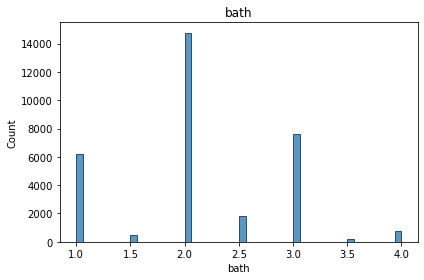

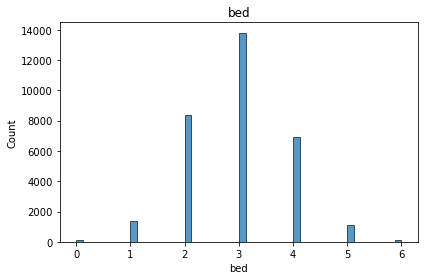

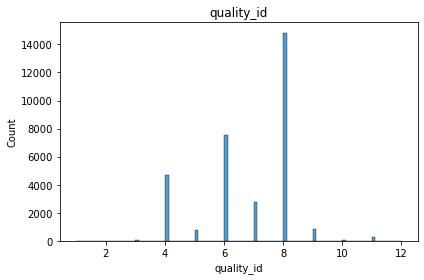

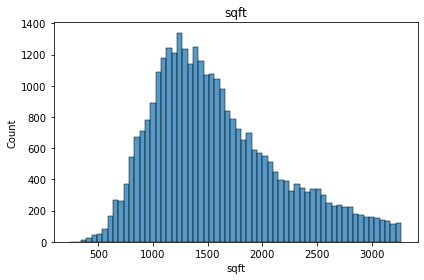

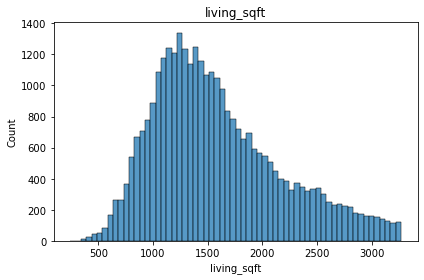

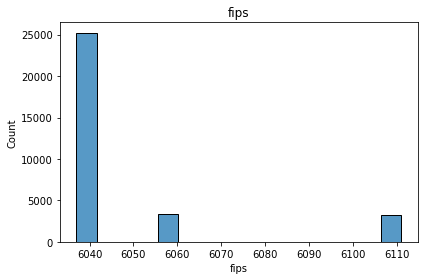

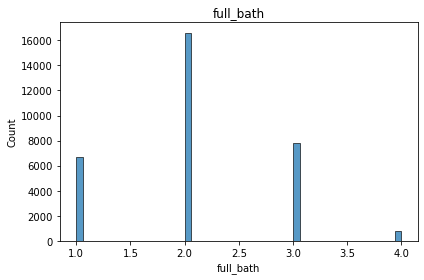

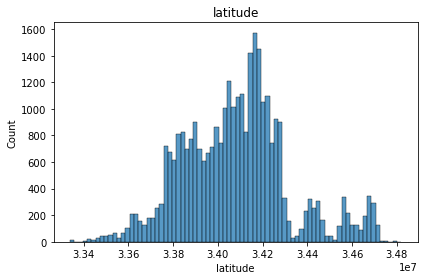

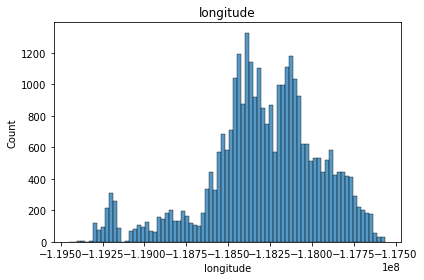

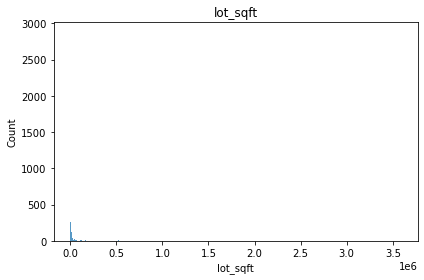

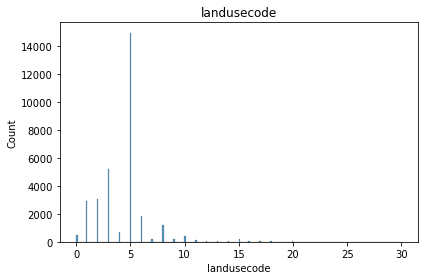

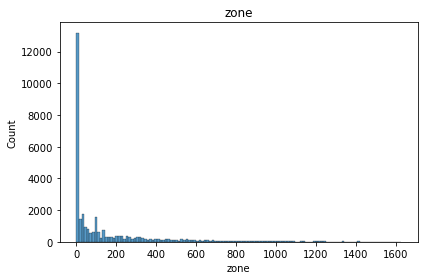

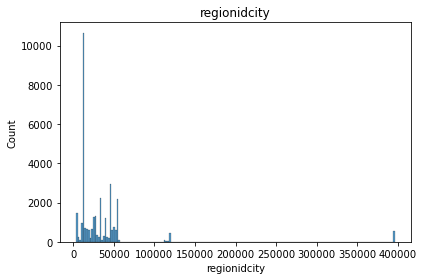

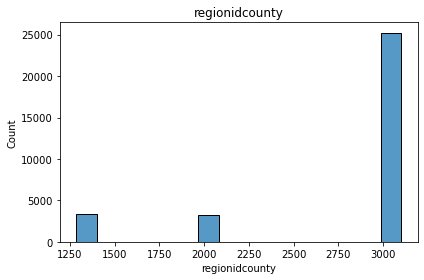

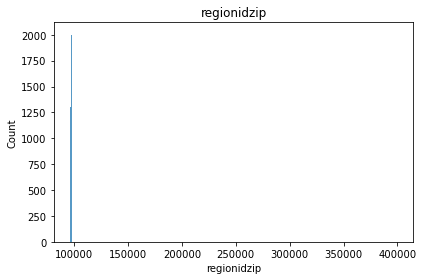

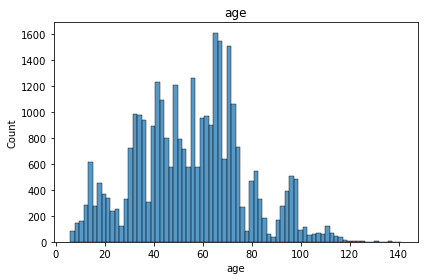

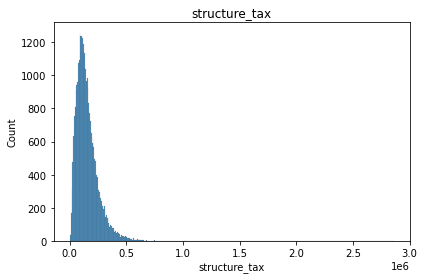

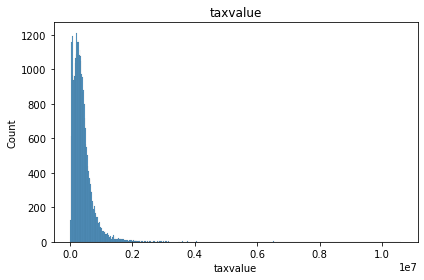

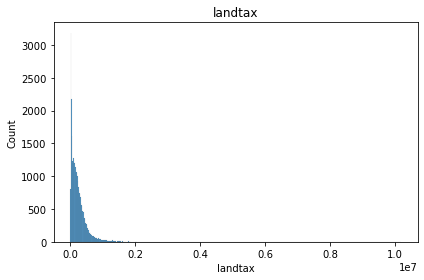

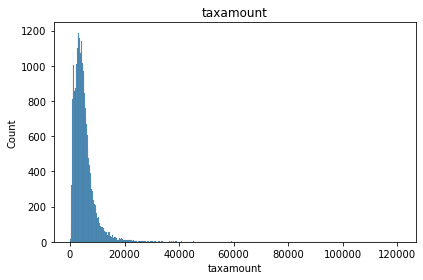

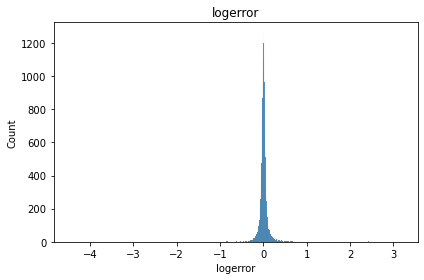

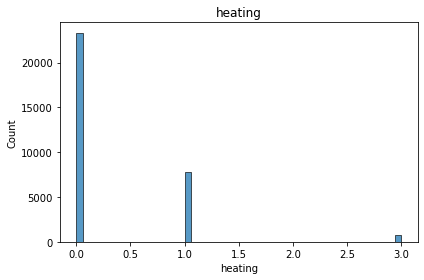

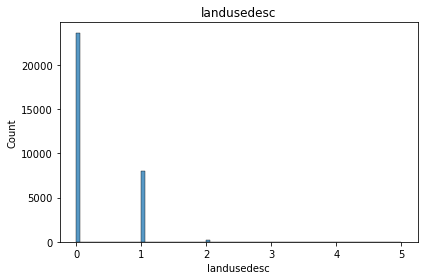

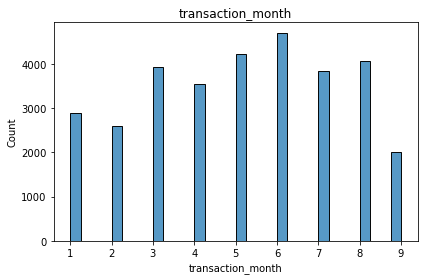

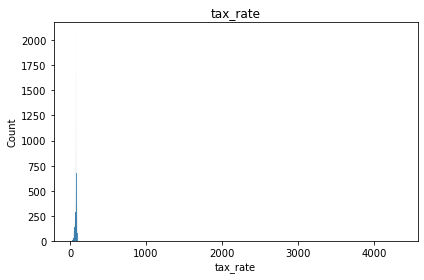

In [5]:
#Univariate Analysis
for col in train.columns:
    plt.title(col)
    sns.histplot(train[col])
    plt.tight_layout()
    plt.show()

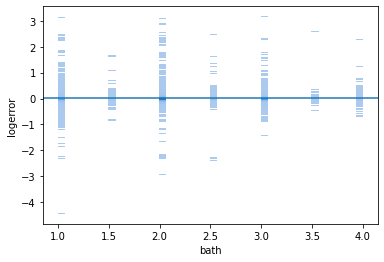

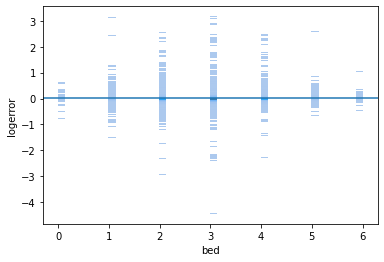

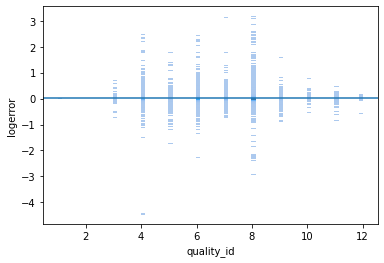

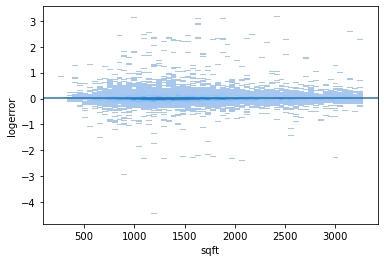

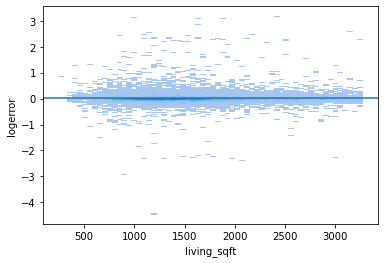

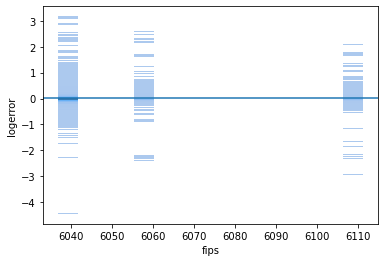

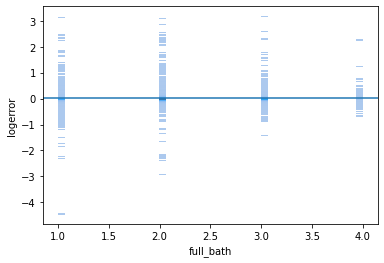

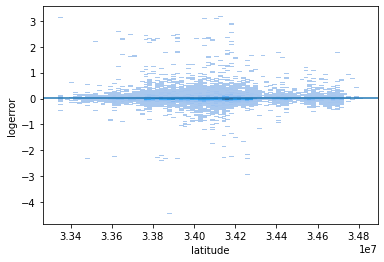

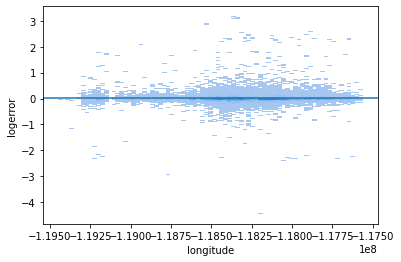

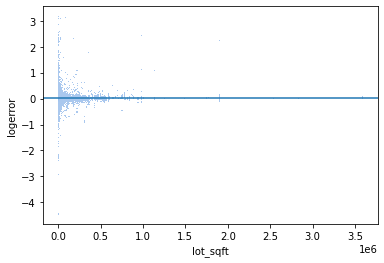

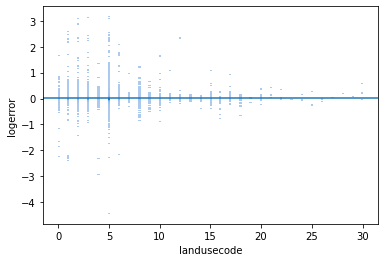

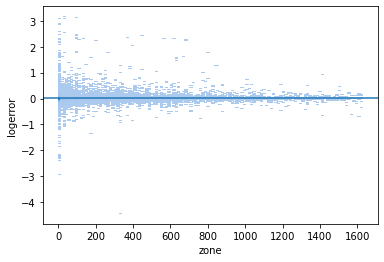

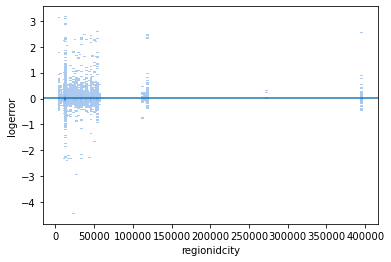

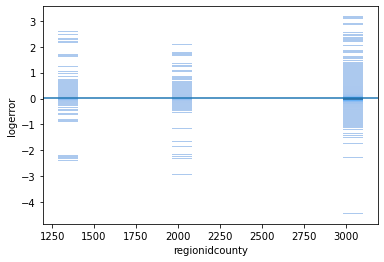

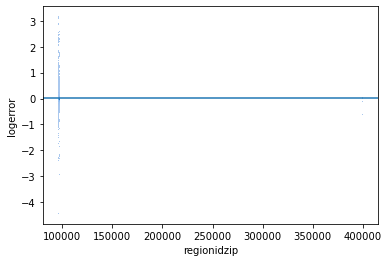

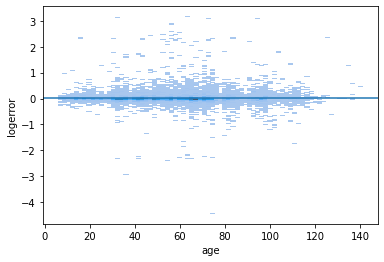

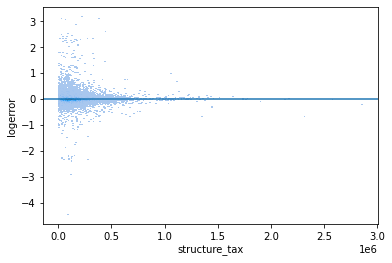

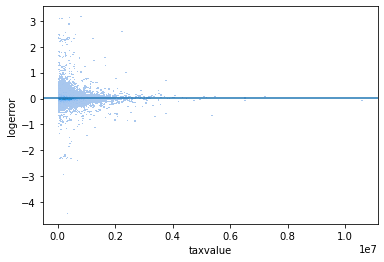

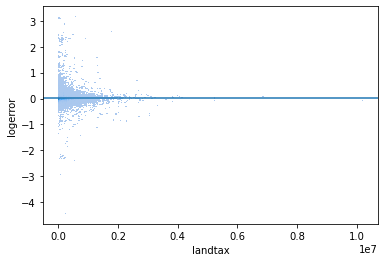

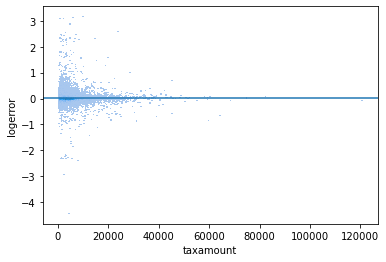

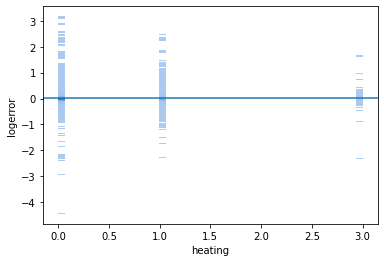

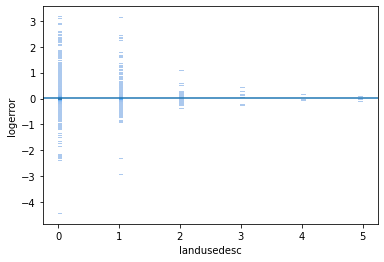

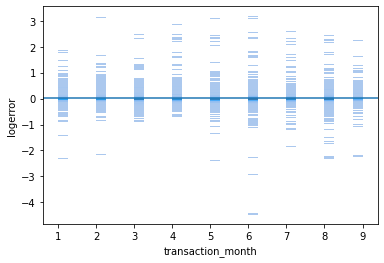

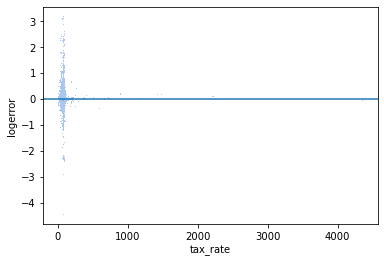

In [6]:
# Bivariate analysis
for col in train.drop(columns='logerror').columns:
    sns.histplot(data=train, x=col, y='logerror')
    plt.axhline(train['logerror'].mean())
    plt.show()

In [7]:
# Scale the data using MinMax Scaler 
# Scale the datasets
scaler = MinMaxScaler()
cols = []
for col in train.columns:
    if train[col].dtype != 'O':
        cols.append(col)

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_mm = train.copy()
validate_mm = validate.copy()
test_mm = test.copy()

# apply our scaler (fit only on train!)
train_mm[cols] = scaler.fit_transform(train[cols])
validate_mm[cols] = scaler.transform(validate[cols])
test_mm[cols] = scaler.transform(test[cols])

**Perpare Takeaways**
- End with 53068 rows
- Went from 68 columns to 25
- Dataset (%): 
    - Train = 60%
    - Validate = 20%
    - Test = 20%
- Univariate
    - bed count has a normal dist
    - might be able to bin age column
    - quality_id may be binned
- Bivariate
    - on average, propertiess with more than 3 bedrooms have greater logerror than properites 3 or less bedrooms
    - LA county has greater logerror variance
    - latitude/longitude have values with more negative logerror
    - lot_sqft variance =/= sqft varinace
    - landusecode >6 has greatest variance
    - zone < 200 
    - age has clusters
    - for taxamount, logerror drops after 100000

---
## Explore

Let's test some hypotheses!

<AxesSubplot:>

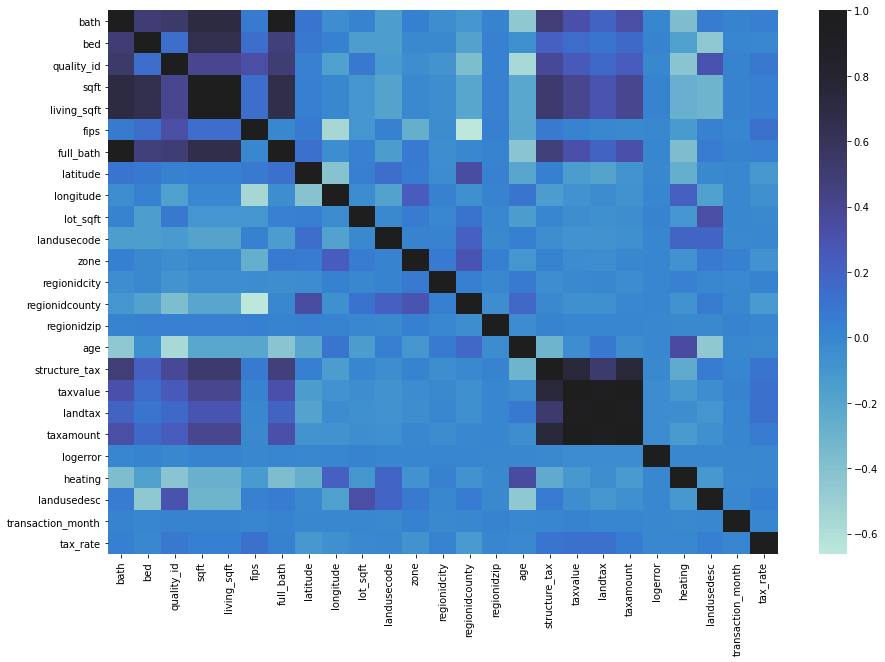

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), center=True)

### Hypothesis 1:
$H_{0}$: The mean logerror for properties with more than 3 bedrooms = mean logerror of props with 3 or less bedrooms

$H_{a}$: The mean logerror for properties with more than 3 bedrooms =/= mean logerror of props with 3 or less bedrooms

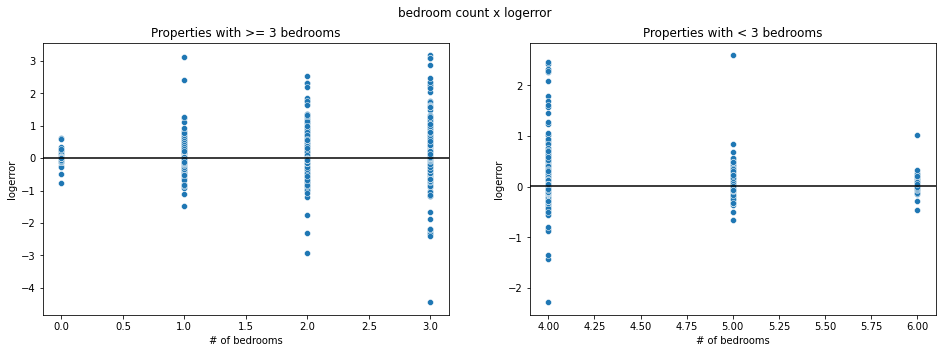

In [9]:
# Visualize bedrooms by logerror to understand potential difference in values of logerror
fig = plt.figure(figsize=(16,5))
plt.suptitle('bedroom count x logerror')

# Plot props with <= 3 bedrooms
plt.subplot(121)
ax=sns.scatterplot(data=train[train.bed <= 3], x='bed', y='logerror')
plt.axhline(train[train.bed <= 3].logerror.mean(), color='black')
plt.title('Properties with >= 3 bedrooms')
plt.xlabel("# of bedrooms")

# Plot props with > 3 bedrooms
plt.subplot(122)
ax=sns.scatterplot(data=train[train.bed > 3], x='bed', y='logerror')
plt.axhline(train[train.bed > 3].logerror.mean(), color='black')
plt.title('Potential Difference in logerror by bedroom count')
plt.title('Properties with < 3 bedrooms')
plt.xlabel("# of bedrooms")
plt.show()

In [10]:
# Set alpha
a = 0.05

# Test the subgroups for difference in logerror variance
stat, p = stats.levene(
    train[train.bed>3].logerror,
    train[train.bed<=3].logerror
)
stat, p

(20.6059187912339, 5.662775540339774e-06)

In [11]:
if p > a:
    print('The variances are equal.')
else:
    print('The variances are different.')

The variances are different.


In [12]:
# Test for similarity in average logerror for both subgroups
t, p = stats.ttest_ind(train[train.bed>3].logerror,
                       train[train.bed<=3].logerror,
                       equal_var = False)
t, p

(4.904632167858864, 9.451828339412064e-07)

In [13]:
if p > a:
    print('We reject the null hypothesis. The means are the same.')
else:
    print('We reject the null hypothesis. The mean logerror for both subgroups is significantly different.')

We reject the null hypothesis. The mean logerror for both subgroups is significantly different.


---
### Hypothesis 2:
$H_{0}$: There is no relationship between tax value and logerror.

$H_{a}$: There is a relationship between tax value and logerror.

Text(0.5, 0, '$ million')

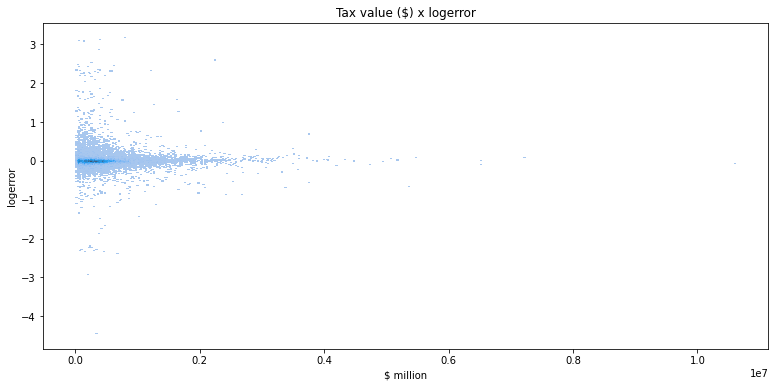

In [14]:
plt.figure(figsize=(13,6))
plt.title('Tax value ($) x logerror')
sns.histplot(x=train.taxvalue, y=train.logerror)
plt.xlabel('$ million')

In [15]:
#set alpha
a = 0.05
# Test for a linear relationship
r, p = stats.spearmanr(train.taxvalue, train.logerror)
r, p

(-0.00944912923716242, 0.09178578577106504)

In [16]:
if p > a:
    print("We accept the null hypothesis. There is no 'linear' relationship between tax value and logerror.")
else:
    print('We reject the null hypothesis. There is a relationship between tax value and logerror.')

We accept the null hypothesis. There is no 'linear' relationship between tax value and logerror.


---
### Hypothesis 3:
Look for clusters using age, sqft

In [17]:
# Create variable with features for clustering
X = train_mm[["sqft", "age"]]

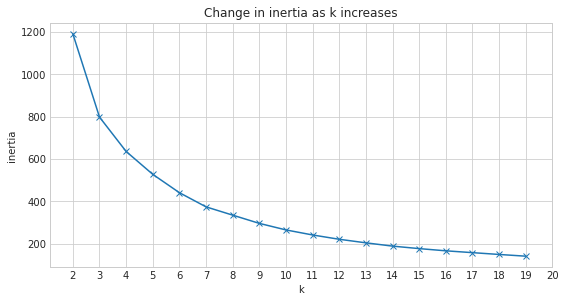

In [18]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

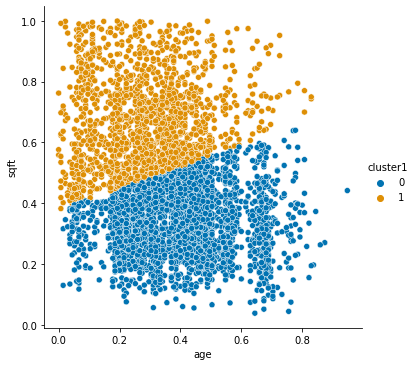

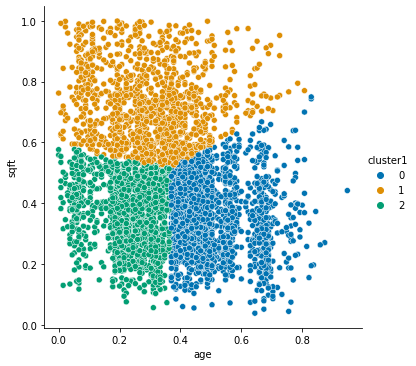

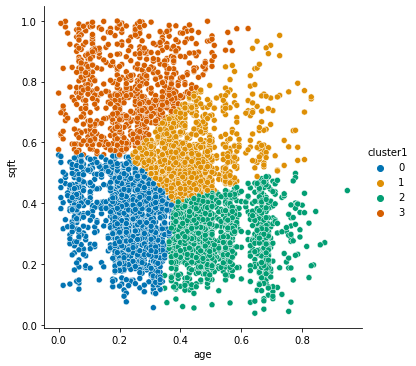

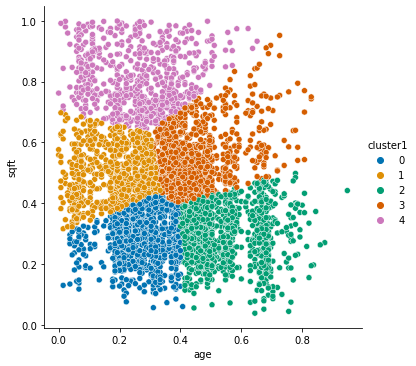

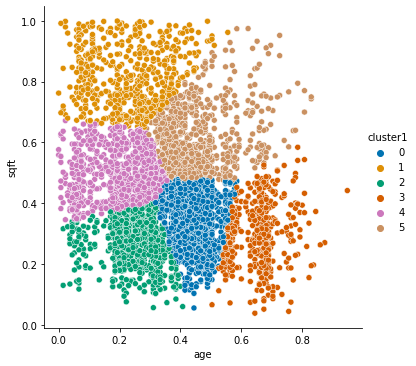

In [19]:
# Visualize potential clusters
for k in range(2,7):
    X = train_mm[["sqft", "age"]]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster1'] = kmeans.predict(X)
    sns.relplot(data=train_mm.head(5_000), y="sqft", x="age", hue="cluster1", palette='colorblind')

In [20]:
kmeans = KMeans(n_clusters=5, random_state=123).fit(X)

# make a new column names cluster in iris and X_scaled dataframe
train['cluster1'] = kmeans.predict(X)
train_mm['cluster1'] = kmeans.predict(X)

# Create centroids for each cluster
centroids = train.groupby('cluster1')['age', 'sqft'].mean()
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

<AxesSubplot:xlabel='sqft', ylabel='age'>

<Figure size 720x720 with 0 Axes>

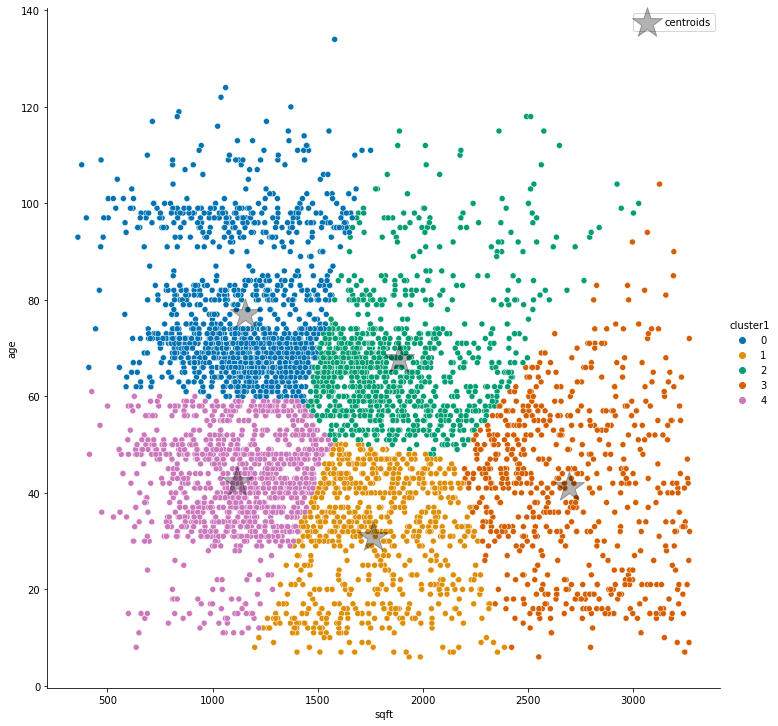

In [21]:
plt.figure(figsize=(10,10))
sns.relplot(data=train.head(5_000), y="age", x="sqft", 
            hue="cluster1", 
            palette='colorblind', 
            height=10)
plt.xlabel('Square Feet')
centroids.plot.scatter(x= 'sqft', y = 'age', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')

In [22]:
cluster1_0 = train_mm[train_mm.cluster1==0].logerror
cluster1_1 = train_mm[train_mm.cluster1==1].logerror
cluster1_2 = train_mm[train_mm.cluster1==2].logerror
cluster1_3 = train_mm[train_mm.cluster1==3].logerror
cluster1_4 = train_mm[train_mm.cluster1==4].logerror

In [23]:
train_mm['cluster1'] = kmeans.predict(train_mm[['age', 'sqft']])
validate_mm['cluster1'] = kmeans.predict(validate_mm[['age', 'sqft']])
test_mm['cluster1'] = kmeans.predict(test_mm[['age', 'sqft']])

In [24]:
# Implement ANOVA test to determine if logerror is equal across all 4 clusters

# Set alpha
a = 0.05

# Run stats test
f, p = stats.f_oneway(cluster1_0, cluster1_1,cluster1_2, cluster1_3, cluster1_4)
f, p

(1.3837845611860753, 0.23668473383109384)

In [25]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 5 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 5 clusters.')

We accept the null hypothesis. The means are the same across all 5 clusters.


---
### Hypothesis 4:
Look for clusters using latitude, longitude, heating

**NOTE: heating only specifices central (0), floor/wall:(1), and other (3)**

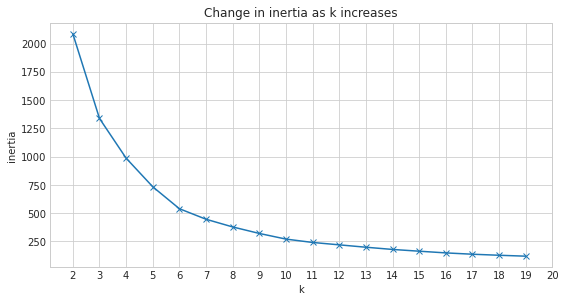

In [26]:
X = train_mm[['latitude', 'longitude', 'heating']]
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

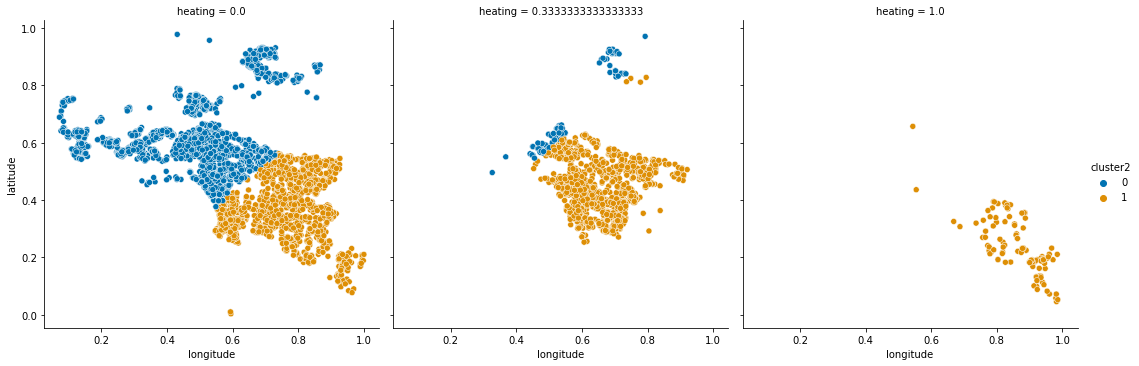

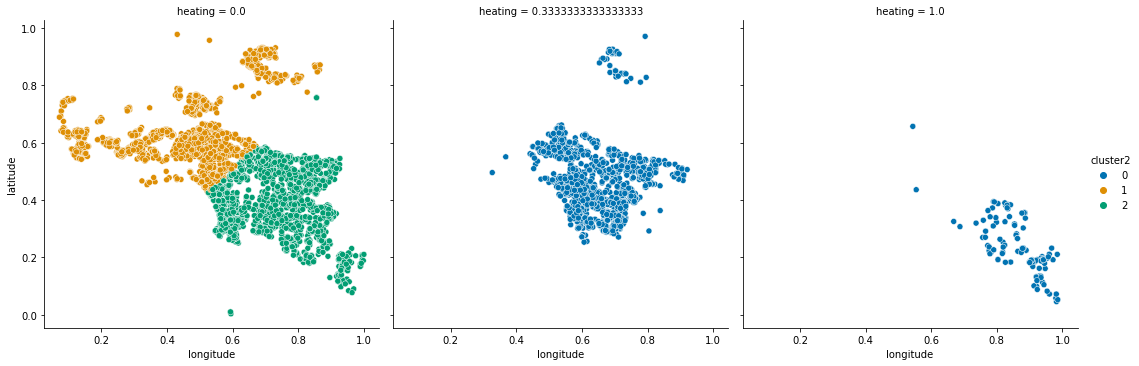

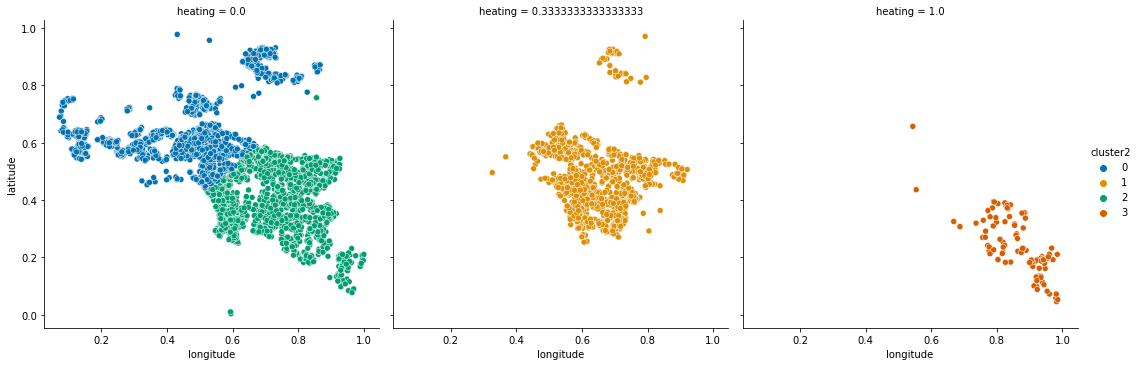

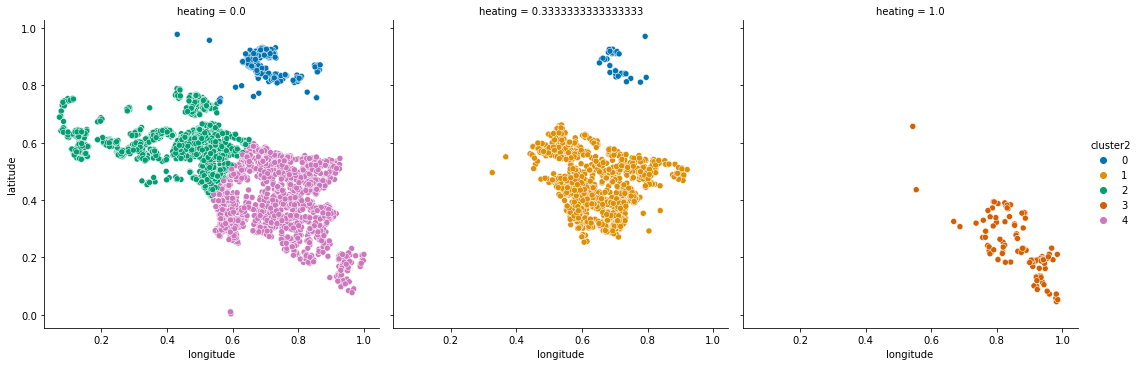

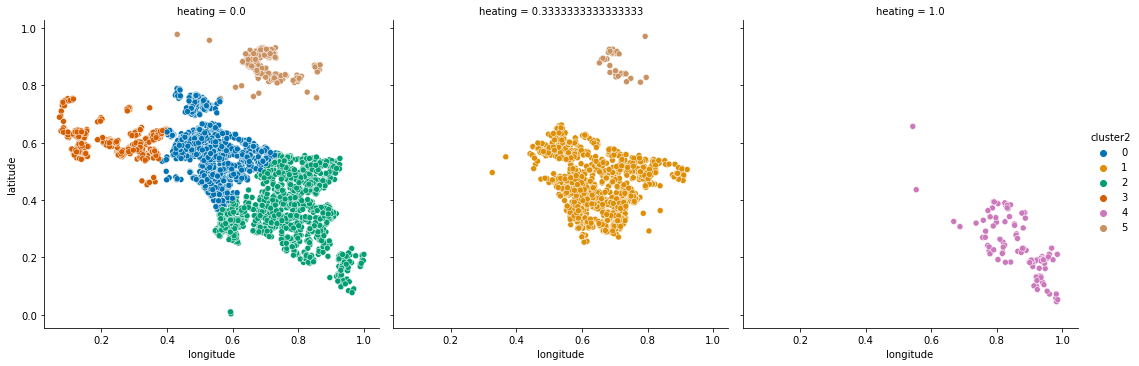

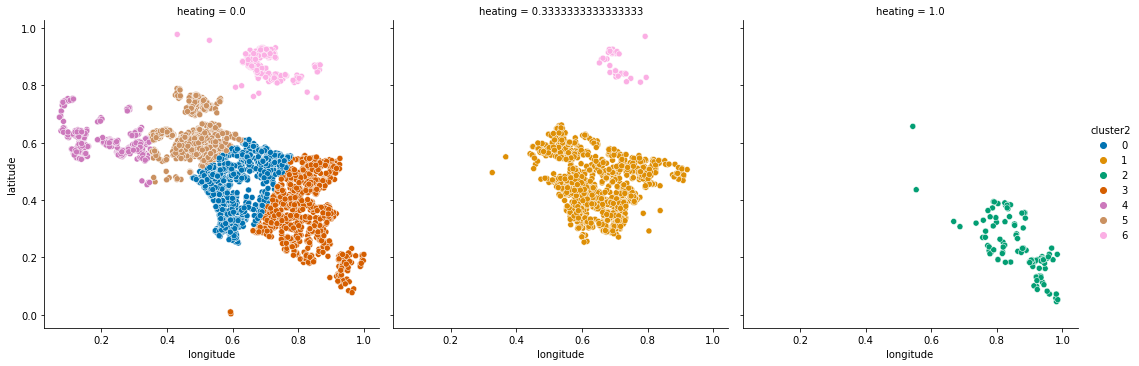

In [27]:
for k in range(2,8):
    X = train_mm[['latitude', 'longitude', 'heating']]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster2'] = kmeans.predict(X)
    sns.relplot(data=train_mm.head(5_000), y="latitude", x="longitude", col='heating', hue='cluster2', palette='colorblind')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 720x720 with 0 Axes>

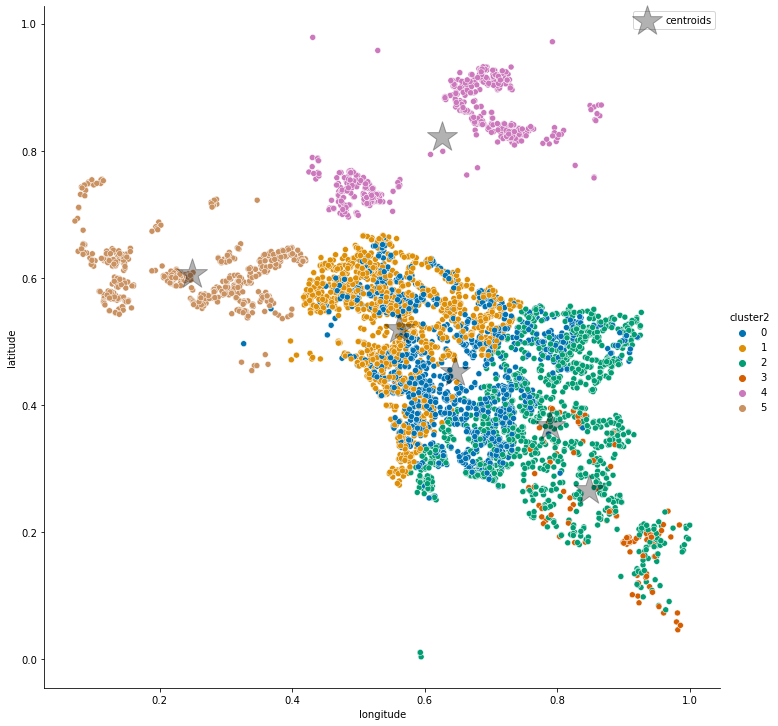

In [28]:
# Indicate number of clusters
# fit the object
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

# Create prediction columns in training dataset
train_mm['cluster2'] = kmeans.predict(X)
train['cluster2'] = kmeans.predict(X)

# Create centroids
centroids2 = train.groupby('cluster2')['latitude', 'longitude', 'heating'].mean()
centroids_scaled2 = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

# Plot
plt.figure(figsize=(10,10))
sns.relplot(data=train_mm.head(5_000), y="latitude", x="longitude",
            hue='cluster2', 
            palette='colorblind',
            height=10)
centroids_scaled2.plot.scatter(x= 'longitude', y = 'latitude', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')

In [29]:
cluster2_0 = train_mm[train_mm.cluster2==0].logerror
cluster2_1 = train_mm[train_mm.cluster2==1].logerror
cluster2_2 = train_mm[train_mm.cluster2==2].logerror
cluster2_3 = train_mm[train_mm.cluster2==3].logerror
cluster2_4 = train_mm[train_mm.cluster2==4].logerror
cluster2_5 = train_mm[train_mm.cluster2==5].logerror



train_mm['cluster2'] = kmeans.predict(train_mm[['latitude', 'longitude', 'heating']])
validate_mm['cluster2'] = kmeans.predict(validate_mm[['latitude', 'longitude', 'heating']])
test_mm['cluster2'] = kmeans.predict(test_mm[['latitude', 'longitude', 'heating']])

# run ANOVA test to determine if logerror is equal across all clusters
# Set alpha
a = 0.05

# Run stats test
f, p = stats.f_oneway(cluster2_0, cluster2_1, cluster2_2, cluster2_3, cluster2_4, cluster2_5)
f, p

(2.7539265494011635, 0.017157088287428672)

In [30]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 6 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 6 clusters.')

We reject the null hypothesis. The means are different across all 6 clusters.


---
### Hypothesis 5:
Look for clusters using tax rate, bath, fips

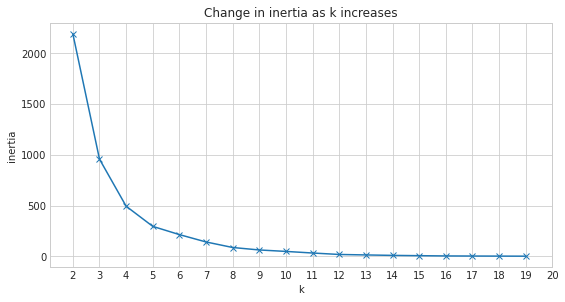

In [31]:
# lets plot inertia vs k
X = train_mm[['bath', 'tax_rate', 'fips']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

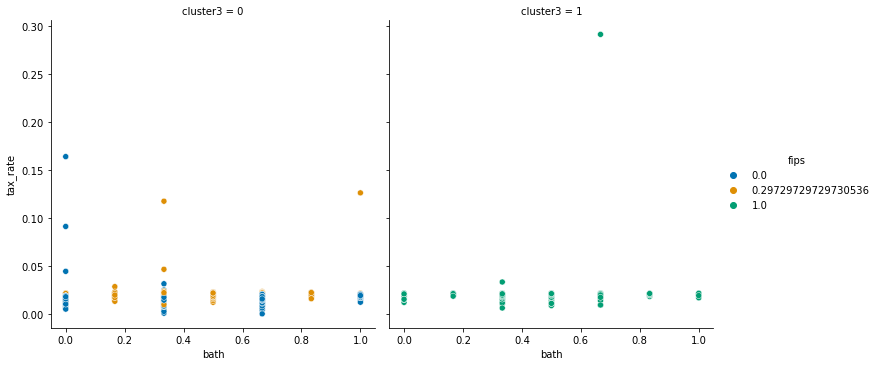

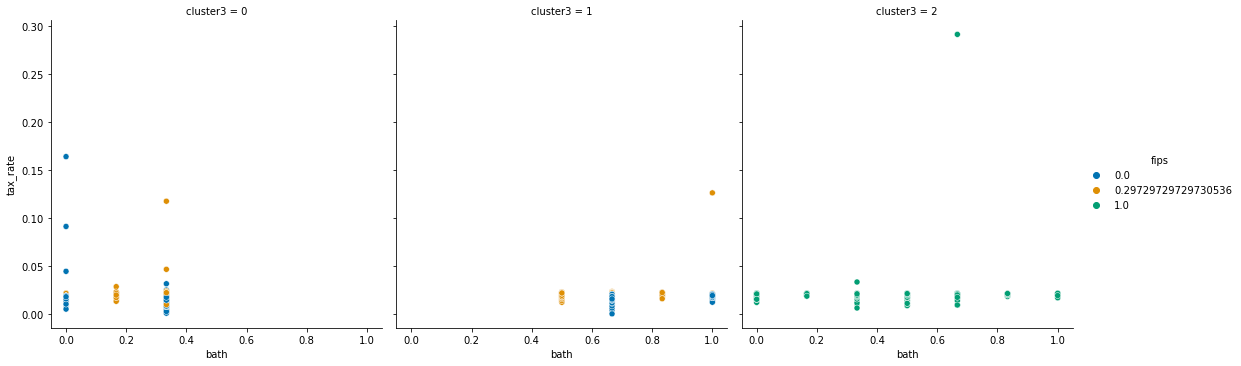

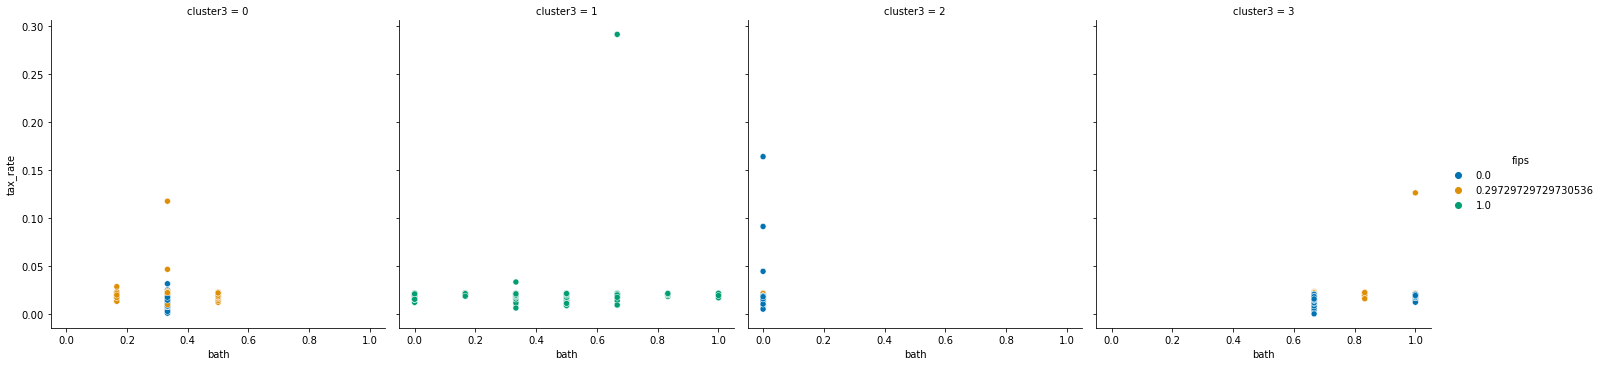

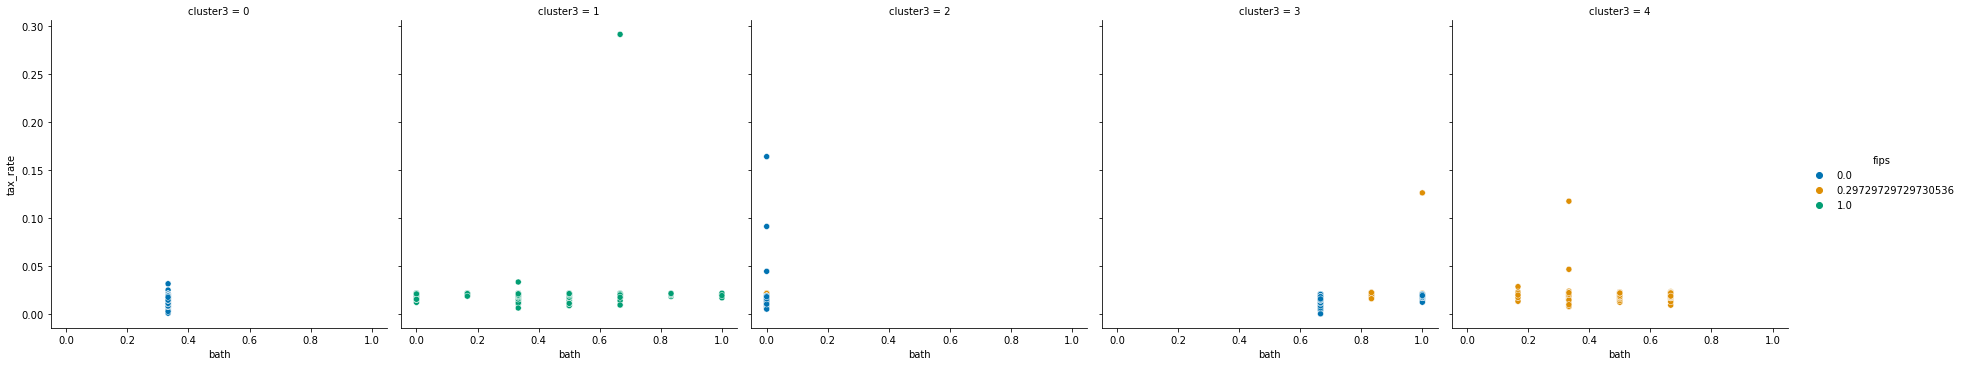

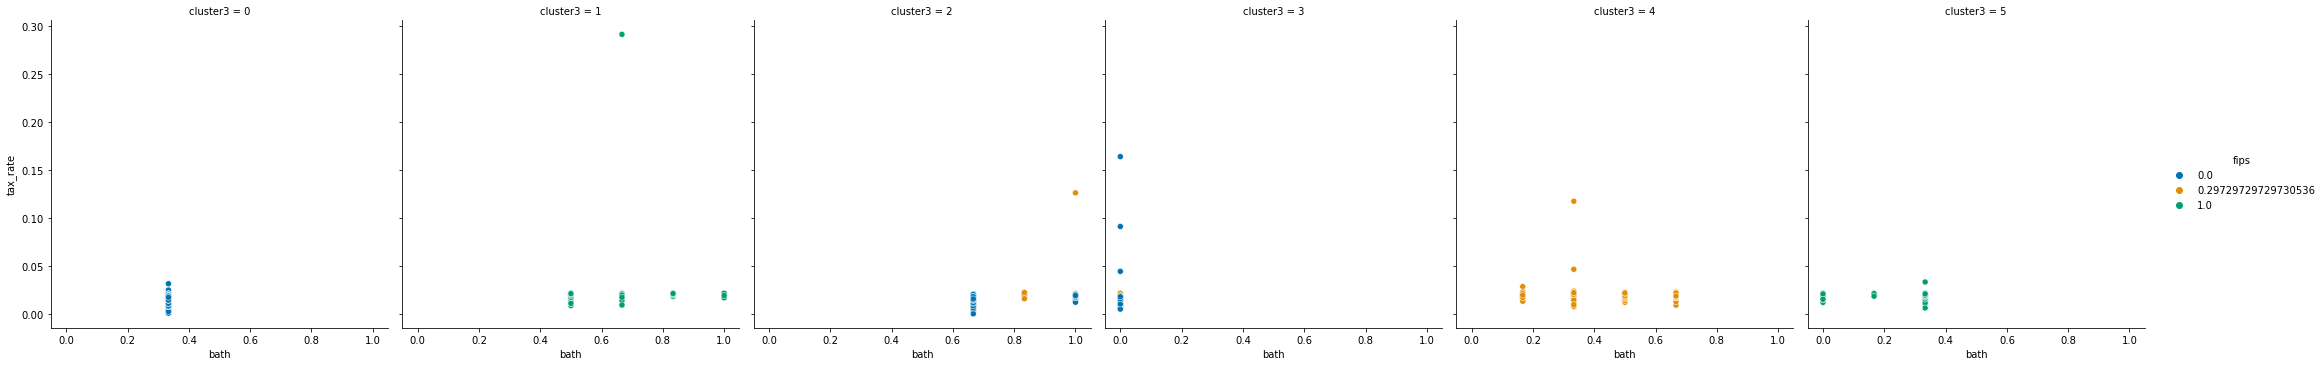

In [32]:
for k in range(2,7):
    X = train_mm[['bath', 'tax_rate', 'fips']]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster3'] = kmeans.predict(X)
    sns.relplot(data=train_mm.head(5_000), y="tax_rate", x="bath", hue='fips', col='cluster3', palette='colorblind')

Text(0.5, 6.79999999999999, '# of bathrooms')

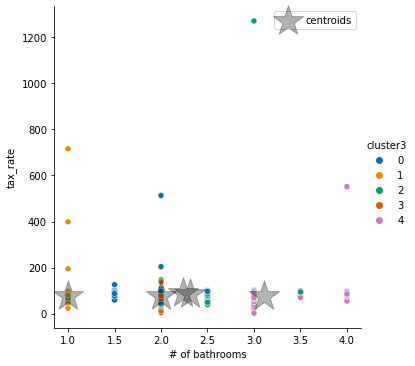

In [33]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_mm['cluster3'] = kmeans.predict(X)
train['cluster3'] = kmeans.predict(X)
centroids3 = train.groupby('cluster3')['bath', 'tax_rate', 'fips'].mean()
centroids_scaled3 = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

sns.relplot(data=train.head(5_000), y="tax_rate", x="bath", hue='cluster3', palette='colorblind')
centroids3.plot.scatter(x= 'bath', y = 'tax_rate', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')
plt.xlabel('# of bathrooms')

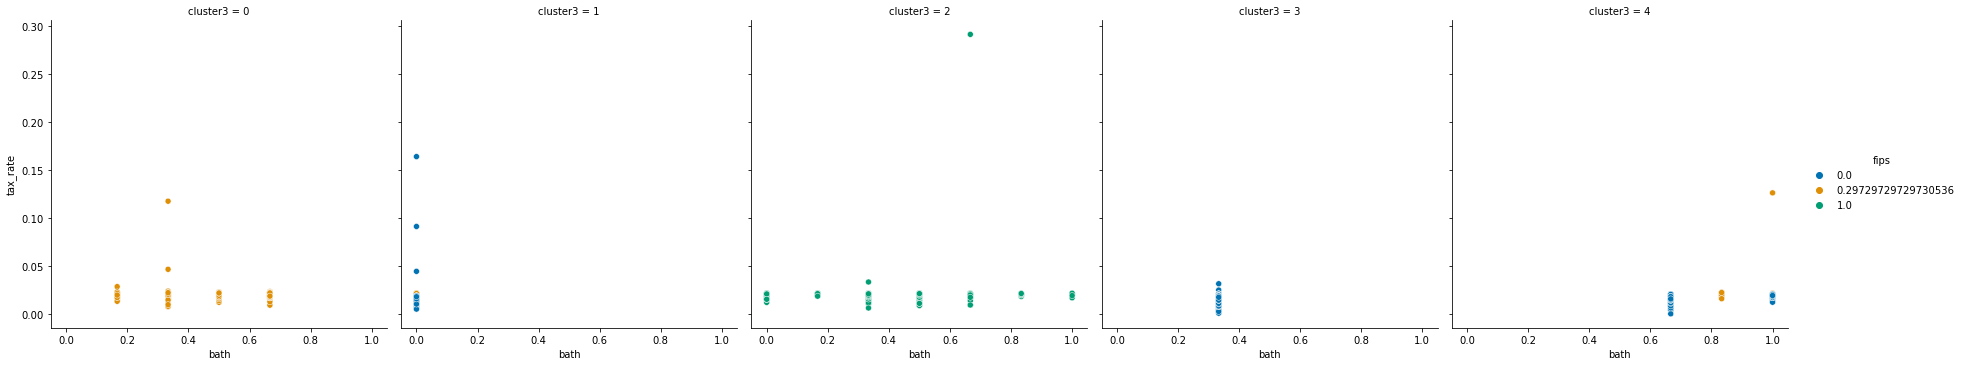

In [34]:
sns.relplot(data=train_mm.head(5_000), y="tax_rate", x="bath", hue='fips', col='cluster3', palette='colorblind')

In [35]:
cluster3_0 = train_mm[train_mm.cluster3==0].logerror
cluster3_1 = train_mm[train_mm.cluster3==1].logerror
cluster3_2 = train_mm[train_mm.cluster3==2].logerror
cluster3_3 = train_mm[train_mm.cluster3==3].logerror
cluster3_4 = train_mm[train_mm.cluster3==4].logerror


train_mm['cluster3'] = kmeans.predict(train_mm[['bath', 'tax_rate', 'fips']])
validate_mm['cluster3'] = kmeans.predict(validate_mm[['bath', 'tax_rate', 'fips']])
test_mm['cluster3'] = kmeans.predict(test_mm[['bath', 'tax_rate', 'fips']])

In [36]:
# run ANOVA test to determine if logerror is equal across all clusters

# Set alpha
a = 0.05

f, p = stats.f_oneway(cluster3_0, cluster3_1, cluster3_2, cluster3_3, cluster3_4)
f, p

(0.4119912789590843, 0.800145024796428)

In [37]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 5 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 5 clusters.')

We accept the null hypothesis. The means are the same across all 5 clusters.


**Explore Takeaways**
- Mean logerror for properties with more than 3 bedrooms is different from the mean logerror of properties with 3 bedrooms or less.
- There is no linear relationship with tax value and logerror.
- When identifing 5 clusters using square feet and age of property, the mean logerror is the same across all 5 clusters.
- When identifing 6 clusters using latitude, longitude, and heating system of property, the mean logerror is different across all 6 clusters.
- When identifing 5 clusters using bathroom count, tax rate, and county of property, the mean logerror is the same across all 6 clusters.

# Model

In [38]:
# Choose mean as our baseline model
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
mean_baseline = y_train.logerror.mean()

y_train['mean_baseline'] = mean_baseline
y_validate['mean_baseline'] = mean_baseline

#RMSE of logerror_pred_mean
rmse_train_mean = mean_squared_error(y_train.logerror, y_train.mean_baseline)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.logerror, y_validate.mean_baseline)**(1/2)

#R^2 Score of mean
r2_baseline_mean = r2_score(y_validate.logerror, y_validate.mean_baseline)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 7))
print(f'R-squared: {r2_baseline_mean}')
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  0.1550308 
Validate/Out-of-Sample:  0.1576582
R-squared: -0.000237277982114259
----------------------------------


In [39]:
# Get baseline model metrics to compare future models
SSE_baseline, ESS_baseline, TSS_baseline, MSE_baseline, RMSE_baseline = m.regression_errors(y_train, 'logerror', 'mean_baseline')

# Create dataframe to hold metrics
df_baseline_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])
df_baseline_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline_mean])
df_baseline_eval

,metric,baseline_error
0,SSE,765.26015
1,MSE,0.02403
2,RMSE,0.15503
3,R2,-0.00024


In [40]:
# Create X scaled
X_train_mm = train_mm.drop(columns='logerror')

X_validate_mm = validate_mm.drop(columns='logerror')

X_test_mm = test_mm.drop(columns='logerror')

In [41]:
train.corr().logerror.sort_values()

taxvalue            -0.02953
taxamount           -0.02949
landtax             -0.02878
structure_tax       -0.02104
transaction_month   -0.01210
quality_id          -0.01175
regionidzip         -0.01032
tax_rate            -0.00599
heating             -0.00579
latitude            -0.00486
age                 -0.00397
landusedesc         -0.00111
fips                -0.00068
regionidcounty       0.00034
cluster1             0.00041
cluster2             0.00535
regionidcity         0.00630
cluster3             0.00638
landusecode          0.00675
zone                 0.00903
full_bath            0.00943
longitude            0.01015
bath                 0.01099
sqft                 0.01515
living_sqft          0.01528
lot_sqft             0.01694
bed                  0.02407
logerror             1.00000
Name: logerror, dtype: float64

In [42]:
best_cols = ['bed', 'bath', 'regionidzip', 'lot_sqft', 'taxamount', 'taxvalue', 'quality_id', 'transaction_month', 'cluster2']

### Oridnary Least Square

In [43]:
# create the model
ols = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
ols.fit(X_train_mm[best_cols], y_train['logerror'])

# predict train
y_train['ols_yhat'] = ols.predict(X_train_mm[best_cols])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train['ols_yhat'])**(1/2)

# predict validate
y_validate['ols_yhat'] = ols.predict(X_validate_mm[best_cols])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['ols_yhat'])**(1/2)

print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS
Training/In-Sample:  0.1548249593111542 
Validation/Out-of-Sample:  0.15732874813600295


In [44]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'logerror', 'ols_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])
df_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline_mean])

df_eval['ols_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.logerror, y_train.ols_yhat)])
df_eval

,metric,baseline_error,ols_error
0,SSE,765.26015,763.22925
1,MSE,0.02403,0.02397
2,RMSE,0.15503,0.15482
3,R2,-0.00024,0.00265


### Lasso, Lars

In [45]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_mm[best_cols], y_train['logerror'])

# predict train
y_train['lars_yhat'] = lars.predict(X_train_mm[best_cols])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train['lars_yhat'])**(1/2)

# predict validate
y_validate['lars_yhat'] = lars.predict(X_validate_mm[best_cols])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['lars_yhat'])**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.15503081152936274 
Validation/Out-of-Sample:  0.15765824531655528


In [46]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'logerror', 'lars_yhat')

df_eval['lars/las_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.logerror, y_train.lars_yhat)])

df_eval

,metric,baseline_error,ols_error,lars/las_error
0,SSE,765.26015,763.22925,765.26015
1,MSE,0.02403,0.02397,0.02403
2,RMSE,0.15503,0.15482,0.15503
3,R2,-0.00024,0.00265,0.00000


### Polynomial Regressor

In [47]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_mm[best_cols])

# transform X_validate_scaled
X_validate_degree3 = pf.transform(X_validate_mm[best_cols])

# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['lm3_yhat'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.lm3_yhat)**(1/2)

# predict validate
y_validate['lm3_yhat'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.lm3_yhat)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1544848735133904 
Validation/Out-of-Sample:  0.1572771334916851


In [48]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'logerror', 'lm3_yhat')

df_eval['polyr_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.logerror, y_train.lm3_yhat)])

df_eval

,metric,baseline_error,ols_error,lars/las_error,polyr_error
0,SSE,765.26015,763.22925,765.26015,759.87994
1,MSE,0.02403,0.02397,0.02403,0.02387
2,RMSE,0.15503,0.15482,0.15503,0.15448
3,R2,-0.00024,0.00265,0.00000,0.00703


### KNeighborsRegressor

In [49]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=45,
                          weights='uniform',
                          algorithm='kd_tree',
                          leaf_size=20,
                         )
knr.fit(X_train_mm[best_cols], y_train.logerror)

# predict train
y_train['knr_yhat'] = knr.predict(X_train_mm[best_cols])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['logerror'], y_train['knr_yhat'])**(1/2)

# predict validate
y_validate['knr_yhat'] = knr.predict(X_validate_mm[best_cols])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['logerror'], y_validate['knr_yhat'])**(1/2)

print("RMSE for K-Neighbors Regressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for K-Neighbors Regressor
Training/In-Sample:  0.152943381234234 
Validation/Out-of-Sample:  0.15983891088614616


In [50]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'logerror', 'knr_yhat')

df_eval['knr_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.logerror, y_train.knr_yhat)])
df_eval

,metric,baseline_error,ols_error,lars/las_error,polyr_error,knr_error
0,SSE,765.26015,763.22925,765.26015,759.87994,744.79102
1,MSE,0.02403,0.02397,0.02403,0.02387,0.02339
2,RMSE,0.15503,0.15482,0.15503,0.15448,0.15294
3,R2,-0.00024,0.00265,0.00000,0.00703,0.02675


### Test on Test

In [51]:
# Convert y_test to dataframe for testing
y_test = pd.DataFrame(y_test)

# Fit the model
knr.fit(X_test_mm[best_cols], y_test.logerror)

# predict
y_test['knr_yhat'] = knr.predict(X_test_mm[best_cols])

# evaluate: rmse
rmse_test = mean_squared_error(y_test['logerror'], y_test['knr_yhat'])**(1/2)

print("RMSE for K-Neighbor Regressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for K-Nearest Regressor
Training/In-Sample:  0.152943381234234 
Validation/Out-of-Sample:  0.15983891088614616 
Test/Out-of-Sample:  0.15942663694311357


In [52]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_test, 'logerror', 'knr_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

#logerror mean
mean_baseline = y_test.logerror.mean()

y_test['mean_baseline'] = mean_baseline

# Get test  baseline model metrics to compare future models
SSE_baseline, ESS_baseline, TSS_baseline, MSE_baseline, RMSE_baseline = m.regression_errors(y_test, 'logerror', 'mean_baseline')

df_eval['knr_error'] = np.array([SSE, MSE, RMSE, r2_score(y_test.logerror, y_test.knr_yhat)])
df_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline_mean])

df_eval['delta_error'] = df_eval.knr_error - df_eval.baseline_error
print('Test Metrics: Baseline vs. KNR Model')
df_eval

Test Metrics: Baseline vs. KNR Model


,metric,knr_error,baseline_error,delta_error
0,SSE,269.77447,277.50440,-7.72992
1,MSE,0.02542,0.02615,-0.00073
2,RMSE,0.15943,0.16169,-0.00227
3,R2,0.02786,-0.00024,0.02809


**Model Takeaways**
- Features used:
    - `bed`
    - `quality_id`
    - `bath`
    - `regionidzip`
    - `lot_sqft`
    - `taxamount`
    - `taxvalue`
    - `transaction_month`
    - `cluster2`
- All models performed inadequetly
- All models except Lars + Lasso performed better than the baseline
    - Lars + Lasso performed almost as well as baseline
- The best performance came from K-Neighbor Regressor
    - Hyperparameters used:
        1. n_neighbors=45
        1. weights='uniform'
        1. algorithm='kd_tree'
        1. leaf_size=20
- Test metrics:
    |Metric|K-Neighbor Regressor| Baseline(Mean)|
    |---------|----------|---------|
    |RMSE|  0.15953| 0.16169|
    |R-Squared| 0.02943| 0.00024|

## Conclusions
- Bedroom count may be a driver of error
- Tax value of property and logerror are not linearly correlated
- There were no useful clusters with sqft and age
- Clusters with latitude, longitude and heating/airconditioning type might create a driver of error
- There were no useful clusters with bathroom count, tax rate, and county
- Ultimately, I found that my models are not adequete predictors of logerror
    - KNR model outperformed the baseline on the test set!

**Next Steps**
- If i had more time and know-how, I would like to investigate any non-linear relationships that these features may have with Zestimate error.